In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import random, randrange, choice, shuffle
from datetime import datetime, timedelta
from itertools import combinations
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all" # Cell의 모든 반환값 출력

# 기본 데이터 세팅

In [2]:
블록원데이터 = pd.DataFrame({"블록명":["S1", "S2", "S3", "S4"], 
                    "중량": [50, 60, 30, 20], 
                    "가로": [10, 10, 5, 5], 
                    "세로":[10, 12, 6, 6], 
                    "표준공기":[2, 3, 1, 2], 
                    "납기":["2024-02-15", "2024-02-15", "2024-02-15", "2024-02-15"],
                    "정반배치":[0, 0, 0, 0]})
블록원데이터.head()

,블록명,중량,가로,세로,표준공기,납기,정반배치
0,S1,50,10,10,2,2024-02-15,0
1,S2,60,10,12,3,2024-02-15,0
2,S3,30,5,6,1,2024-02-15,0
3,S4,20,5,6,2,2024-02-15,0


In [3]:
정반원데이터 = pd.DataFrame({"정반명":["A", "B", "C"],
                   "가능중량":[100, 100, 30],
                   "가로":[10, 10, 5],
                   "세로":[20, 10, 10],
                   })
정반원데이터.head()

,정반명,가능중량,가로,세로
0,A,100,10,20
1,B,100,10,10
2,C,30,5,10


In [4]:
정반원데이터.index[정반원데이터["정반명"]=="B"].values[0]

1

In [5]:
start_date = datetime(2024, 2, 1)
end_date = datetime(2024, 2, 28)
날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
날짜집합

DatetimeIndex(['2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',
               '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
               '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12',
               '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16',
               '2024-02-17', '2024-02-18', '2024-02-19', '2024-02-20',
               '2024-02-21', '2024-02-22', '2024-02-23', '2024-02-24',
               '2024-02-25', '2024-02-26', '2024-02-27', '2024-02-28'],
              dtype='datetime64[ns]', freq='D')

In [6]:
블록집합 = 블록원데이터["블록명"].unique().tolist()
블록집합

['S1', 'S2', 'S3', 'S4']

In [7]:
최초정반집합 = 정반원데이터["정반명"].unique().tolist()
최초정반집합

['A', 'B', 'C']

# 블록 데이터 전처리 함수

In [8]:
import functools
def unpack_df_columns(func):
    @functools.wraps(func)
    def _unpack_df_columns(*args, **kwargs):
        series = args[0]
        return func(*series.values)
    return _unpack_df_columns

In [9]:
@unpack_df_columns
def 최소착수요구일구하기(납기, 공기):
    result = pd.to_datetime(납기) - timedelta(days=int(공기))
    return result.date()

In [10]:
착수일가중치, 공기가중치, 크기가중치 = 0.7, 0.5, 0.5

@unpack_df_columns
def 블록우선순위구하기(날순, 공순, 크순):
    global 착수일가중치, 공기가중치, 크기가중치
    result = np.round((날순*착수일가중치 + 공순*공기가중치 + 크순*크기가중치)/3,1)
    return result

@unpack_df_columns
def 블록사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)
    result = (길이2, 길이1)
    return result

In [11]:
def 블록데이터전처리(블록원데이터):
    df1 = 블록원데이터.copy()
    df1["사이즈"] = df1[["가로", "세로"]].apply(블록사이즈튜플만들기, axis=1)
    df1["납기"] = pd.to_datetime(df1["납기"])
    df1["면적"] = df1.eval("가로*세로")
    df1["최소착수요구일"] = df1[["납기", "표준공기"]].apply(최소착수요구일구하기, axis=1)
    df1["날짜순서"] = df1["최소착수요구일"].rank()
    df1["공기순서"] = df1["표준공기"].rank(ascending=False)
    df1["크기순서"] = df1["면적"].rank(ascending=False)
    df1["우선순위"] = df1[["날짜순서", "공기순서", "크기순서"]].apply(블록우선순위구하기, axis=1)
    
    df1 = df1.drop(['가로', '세로'], axis=1)
    df1 = df1.sort_values(by=["우선순위"])
    return df1

In [12]:
df1 = 블록데이터전처리(블록원데이터)
df1

,블록명,중량,표준공기,납기,정반배치,사이즈,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위
1,S2,60,3,2024-02-15,0,"(10, 12)",120,2024-02-12,1.0,1.0,1.0,0.6
0,S1,50,2,2024-02-15,0,"(10, 10)",100,2024-02-13,2.5,2.5,2.0,1.3
3,S4,20,2,2024-02-15,0,"(5, 6)",30,2024-02-13,2.5,2.5,3.5,1.6
2,S3,30,1,2024-02-15,0,"(5, 6)",30,2024-02-14,4.0,4.0,3.5,2.2


In [13]:
공기가중치 = [9, 0.5]
크기가중치 = [0.5, 9]
착수일가중치 = 0.5
for 공기가중치, 크기가중치 in zip(공기가중치, 크기가중치):
    df2 = 블록데이터전처리(블록원데이터)
    print(df2[["블록명", "우선순위"]])

  블록명  우선순위
1  S2   3.3
0  S1   8.2
3  S4   8.5
2  S3  13.2
  블록명  우선순위
1  S2   3.3
0  S1   6.8
3  S4  11.3
2  S3  11.8


# 정반 데이터 전처리 함수

In [14]:
중량가중치, 크기가중치 = 0.5, 0.7

@unpack_df_columns
def 정반우선순위구하기(중순, 크순):
    global 중량가중치, 크기가중치
    result = np.round((중순*중량가중치 + 크순*크기가중치)/3,1)
    return result

@unpack_df_columns
def 정반사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)
    result = (길이1, 길이2)
    return result

In [15]:
def 정반데이터전처리(정반원데이터):
    df = 정반원데이터.copy()
    
    df["사이즈"] = df[["가로", "세로"]].apply(정반사이즈튜플만들기, axis=1)
    df["면적"] = df.eval("가로*세로")
    df["중량순서"] = df["가능중량"].rank(ascending=False)
    df["크기순서"] = df["면적"].rank(ascending=False)
    df["우선순위"] = df[["중량순서", "크기순서"]].apply(정반우선순위구하기, axis=1)
    
    df = df.drop(['가로', '세로'], axis=1)
    df = df.sort_values(by=["우선순위"])
    return df

In [16]:
df2 = 정반데이터전처리(정반원데이터)
df2

,정반명,가능중량,사이즈,면적,중량순서,크기순서,우선순위
0,A,100,"(20, 10)",200,1.5,1.0,0.5
1,B,100,"(10, 10)",100,1.5,2.0,0.7
2,C,30,"(10, 5)",50,3.0,3.0,1.2


In [17]:
중량가중치들 = [0.9, 0.01]
크기가중치들 = [0.01, 3]

for 중량가중치, 크기가중치 in zip(중량가중치들, 크기가중치들):
    df2 = 정반데이터전처리(정반원데이터)
    print(df2[["정반명", "우선순위"]])

  정반명  우선순위
0   A   0.5
1   B   0.5
2   C   0.9
  정반명  우선순위
0   A   1.0
1   B   2.0
2   C   3.0


# 변수정리함수

In [18]:
def 블록변수정리(블록데이터, target_block):
    블록 = dict()
    블록["블록명"] = target_block
    블록["인덱스"] =  블록데이터[블록데이터["블록명"]==target_block].index.values[0]
    블록["중량"] = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    블록["사이즈"] = 블록데이터[블록데이터["블록명"]==target_block]["사이즈"].values[0]
    블록["면적"] = 블록데이터[블록데이터["블록명"]==target_block]["면적"].values[0]
    블록["표준공기"] = 블록데이터[블록데이터["블록명"]==target_block]["표준공기"].values[0]
    블록["최소착수요구일"] = 블록데이터[블록데이터["블록명"]==target_block]["최소착수요구일"].values[0]
    return 블록

In [19]:
블록변수정리(df1, "S1")

{'블록명': 'S1',
 '인덱스': 0,
 '중량': 50,
 '사이즈': (10, 10),
 '면적': 100,
 '표준공기': 2,
 '최소착수요구일': datetime.date(2024, 2, 13)}

In [20]:
def 정반변수정리(정반데이터, 정반명):
    정반 = dict()
    정반["정반명"] = 정반명
    정반["가능중량"] = 정반데이터[정반데이터["정반명"]==정반명]["가능중량"].values[0]
    정반["사이즈"] = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    정반["면적"] = 정반데이터[정반데이터["정반명"]==정반명]["면적"].values[0]
    
    return 정반

In [21]:
A = 정반변수정리(df2, "A")
A

{'정반명': 'A', '가능중량': 100, '사이즈': (20, 10), '면적': 200}

# 정반가능중량 조건 적합도 검토

In [22]:
def 정반가능중량검토(target_block, 블록데이터, 정반, 정반데이터):
    블록중량 = 블록데이터[블록데이터["블록명"]==target_block]["중량"].values[0]
    정반가능중량 = 정반데이터[정반데이터["정반명"]==정반]["가능중량"].values[0]
    
    if 정반가능중량 > 블록중량: 
        return "적합"
    else:
        return "부적합"

In [23]:
정반가능중량검토("S1", df1, "A", df2)

'적합'

# 면적 달력

In [24]:
def create_면적달력(시작년:int, 시작월:int, 종료년:int, 종료월:int, 정반데이터):
    start_date = datetime(시작년, 시작월, 1)
    end_date = datetime(종료년, 종료월, 28)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    면적달력 = pd.DataFrame()
    면적달력.index = 날짜집합
   
    for 정반 in 정반집합:
        면적달력[f"{정반}"] = 정반데이터[정반데이터["정반명"]==정반]["면적"].values[0]

    return 면적달력

In [25]:
면적달력 = create_면적달력(2024, 2, 2024, 2, df2)
면적달력.head(3)

,A,B,C
2024-02-01,200,100,50
2024-02-02,200,100,50
2024-02-03,200,100,50


In [376]:
def get_최선조기착수일후보(면적달력, 정반리스트, 대상블록, 블록데이터):
    result_dict = dict()
    
    블록면적 = 블록데이터[블록데이터["블록명"]==대상블록]["면적"].values[0]
    표준공기 = 블록데이터[블록데이터["블록명"]==대상블록]["표준공기"].values[0]
    print(f"블록명:{대상블록}, 블록면적:{블록면적}, 표준공기:{표준공기}")
    
    for 대상정반 in 정반리스트:
        대상정반면적리스트 = 면적달력[f"{대상정반}"].iloc[:].values
        
        for i in range(len(대상정반면적리스트)):
            조회시점인덱스 = i
            조회구간면적리스트 = 대상정반면적리스트[조회시점인덱스:조회시점인덱스+표준공기]
            조회기간최소면적 = min(조회구간면적리스트)
            print(f">>> 조회구간면적리스트: {조회구간면적리스트}, 조회기간최소면적: {조회기간최소면적}")
            
            if 조회기간최소면적 > 블록면적 * 1.05: # 블록크기 5% 가중
                최선조기착수일 = 면적달력.index[조회시점인덱스]
                result_dict[대상정반] = 최선조기착수일
                print(f">>> 대상정반:{대상정반}, 조회기간최소면적:{조회기간최소면적}, 블록명:{대상블록}, 최선조기착수일: {최선조기착수일}")  
                break
        
    return result_dict

In [377]:
정반리스트 = ["A", "B"]
최선조기착수일후보 = get_최선조기착수일후보(면적달력, 정반리스트, "S2", df1)
최선조기착수일후보

블록명:S2, 블록면적:120, 표준공기:3
>>> 조회구간면적리스트: [50 50 50], 조회기간최소면적: 50
>>> 조회구간면적리스트: [50 50 50], 조회기간최소면적: 50
>>> 조회구간면적리스트: [50 50 50], 조회기간최소면적: 50
>>> 조회구간면적리스트: [50 50 10], 조회기간최소면적: 10
>>> 조회구간면적리스트: [50 10 10], 조회기간최소면적: 10
>>> 조회구간면적리스트: [10 10 10], 조회기간최소면적: 10
>>> 조회구간면적리스트: [10 10 10], 조회기간최소면적: 10
>>> 조회구간면적리스트: [10 10 10], 조회기간최소면적: 10
>>> 조회구간면적리스트: [10 10 20], 조회기간최소면적: 10
>>> 조회구간면적리스트: [10 20 20], 조회기간최소면적: 10
>>> 조회구간면적리스트: [20 20 20], 조회기간최소면적: 20
>>> 조회구간면적리스트: [20 20 90], 조회기간최소면적: 20
>>> 조회구간면적리스트: [20 90 90], 조회기간최소면적: 20
>>> 조회구간면적리스트: [90 90 90], 조회기간최소면적: 90
>>> 조회구간면적리스트: [90 90 90], 조회기간최소면적: 90
>>> 조회구간면적리스트: [90 90 90], 조회기간최소면적: 90
>>> 조회구간면적리스트: [ 90  90 170], 조회기간최소면적: 90
>>> 조회구간면적리스트: [ 90 170 200], 조회기간최소면적: 90
>>> 조회구간면적리스트: [170 200 200], 조회기간최소면적: 170
>>> 대상정반:A, 조회기간최소면적:170, 블록명:S2, 최선조기착수일: 2024-02-19 00:00:00


KeyError: 'B'

In [ ]:
def get_최선조기착수대상(최선조기착수일후보):
    # 복수의 경우 셔플후 랜덤 선택
    temp_list = list(최선조기착수일후보.items())
    shuffle(temp_list)
    최선조기착수일후보 = dict(temp_list)

    earliest_item = min(최선조기착수일후보.items(), key=lambda x: x[1])
    최선정반 = earliest_item[0]
    최선착수일 = earliest_item[1].strftime('%Y-%m-%d')
    return 최선정반, 최선착수일

In [ ]:
최선조기착수대상 = get_최선조기착수대상(최선조기착수일후보)
최선조기착수대상

In [214]:
def update_면적달력(면적달력, 최선조기착수대상, 배치블록명, 블록데이터):
    
    정반리스트 = 면적달력.columns.tolist()
    블록면적 = 블록데이터[블록데이터["블록명"]==배치블록명]["면적"].values[0]
    표준공기 = 블록데이터[블록데이터["블록명"]==배치블록명]["표준공기"].values[0]
    블록착수일 = 최선조기착수대상[1]
    시점인덱스 = list(면적달력.index.strftime('%Y-%m-%d')).index(블록착수일)
    정반 = 최선조기착수대상[0]
        

    조회기간면적리스트 = 면적달력[f"{정반}"].iloc[시점인덱스:시점인덱스+표준공기].values

    if min(조회기간면적리스트) >= 블록면적:
        for idx, 대상일면적 in enumerate(조회기간면적리스트):
            수정면적 = 대상일면적 - 블록면적
            대상일인덱스 = 시점인덱스 + idx
            면적달력[f"{정반}"].iloc[대상일인덱스:대상일인덱스+1] = 수정면적
    else:
        print("면적이 부족하여 블록을 배치할 수 없습니다.")
    
    return 면적달력
    

In [215]:
면적달력 = update_면적달력(면적달력, 최선조기착수대상, "S4", df1)
면적달력.head(10)

면적이 부족하여 블록을 배치할 수 없습니다.


,A
2024-02-01,20
2024-02-02,20
2024-02-03,20
2024-02-04,20
2024-02-05,20
2024-02-06,80
2024-02-07,110
2024-02-08,110
2024-02-09,110
2024-02-10,110


# 블록명 달력

In [216]:
def create_블록명달력(시작년:int, 시작월:int, 종료년:int, 종료월:int, 정반데이터):
    start_date = datetime(시작년, 시작월, 1)
    end_date = datetime(종료년, 종료월, 28)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    달력 = pd.DataFrame()
    달력.index = 날짜집합
    
    for 정반 in 정반집합:
        달력[정반] = [[] for _ in range(len(날짜집합))]
        
    return 달력

In [217]:
블록명달력 = create_블록명달력(2024, 2, 2024, 2, df2)
블록명달력

,A,B,C
2024-02-01,[],[],[]
2024-02-02,[],[],[]
2024-02-03,[],[],[]
2024-02-04,[],[],[]
2024-02-05,[],[],[]
2024-02-06,[],[],[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


In [218]:
def update_블록명달력(블록명달력, 최선정반, 블록데이터, block_names, best_st_date):
    
    달력 = 블록명달력
    결과모음 = [[] for _ in range(len(날짜집합))]

    for block_name, 블록착수일 in zip(block_names, best_st_date):

        시점인덱스 = list(달력.index.strftime('%Y-%m-%d')).index(블록착수일)
        표준공기 = 블록데이터[블록데이터["블록명"]==block_name]["표준공기"].values[0]

        for i in 결과모음[시점인덱스:시점인덱스+표준공기]:
            i.append(block_name)
            
    달력[f"{최선정반}"] = 결과모음

    return 달력

In [219]:
block_names = ["S1", "S2", "S3"]
block_sizes = [(2, 5), (3, 4), (2, 5)]
best_st_date = ["2024-02-01", "2024-02-03", "2024-02-06"]
블록명달력 = update_블록명달력(블록명달력, "B", df1, block_names, best_st_date)
블록명달력

,A,B,C
2024-02-01,[],[S1],[]
2024-02-02,[],[S1],[]
2024-02-03,[],[S2],[]
2024-02-04,[],[S2],[]
2024-02-05,[],[S2],[]
2024-02-06,[],[S3],[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


In [220]:
block_names = ["S1", "S2", "S3", "S4"]
block_sizes = [(2, 5), (3, 4), (2, 5), (4, 5)]
best_st_date = ["2024-02-01", "2024-02-03", "2024-02-06", "2024-02-02"]
블록명달력 = update_블록명달력(블록명달력, "B", df1, block_names, best_st_date)
블록명달력

,A,B,C
2024-02-01,[],[S1],[]
2024-02-02,[],"[S1, S4]",[]
2024-02-03,[],"[S2, S4]",[]
2024-02-04,[],[S2],[]
2024-02-05,[],[S2],[]
2024-02-06,[],[S3],[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


# 사이즈 달력

In [221]:
def create_사이즈달력(시작년:int, 시작월:int, 종료년:int, 종료월:int, 정반데이터):
    start_date = datetime(시작년, 시작월, 1)
    end_date = datetime(종료년, 종료월, 28)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    달력 = pd.DataFrame()
    달력.index = 날짜집합
    
    for 정반 in 정반집합:
        달력[정반] = [[] for _ in range(len(날짜집합))]
        
    return 달력

In [222]:
사이즈달력 = create_사이즈달력(2024, 2, 2024, 2, df2)
사이즈달력

,A,B,C
2024-02-01,[],[],[]
2024-02-02,[],[],[]
2024-02-03,[],[],[]
2024-02-04,[],[],[]
2024-02-05,[],[],[]
2024-02-06,[],[],[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


In [223]:
def update_사이즈달력(사이즈달력, 최선정반, 블록데이터, block_names, block_sizes, best_st_date):
    
    달력 = 사이즈달력
    결과모음 = [[] for _ in range(len(날짜집합))]

#     for block_size, 블록착수일 in zip(block_sizes, best_st_date):
        
    for i in range(len(block_names)):
        블록명 = block_names[i]
        블록사이즈 = block_sizes[i]
        블록착수일 = best_st_date[i]
        
        표준공기 = 블록데이터[블록데이터["블록명"]==블록명]["표준공기"].values[0]
        시점인덱스 = list(달력.index.strftime('%Y-%m-%d')).index(블록착수일)
        
#         표준공기 = 블록데이터[블록데이터["블록명"]==block_names[-1]]["표준공기"].values[0]

        for i in 결과모음[시점인덱스:시점인덱스+표준공기]:
            i.append(블록사이즈)
            
    달력[f"{최선정반}"] = 결과모음

    return 달력

In [224]:
block_names = ["S1", "S2", "S3"]
block_sizes = [(2, 5), (3, 4), (2, 5)]
best_st_date = ["2024-02-01", "2024-02-03", "2024-02-06"]
사이즈달력 = update_사이즈달력(사이즈달력, "B", df1, block_names,block_sizes, best_st_date)
사이즈달력

,A,B,C
2024-02-01,[],"[(2, 5)]",[]
2024-02-02,[],"[(2, 5)]",[]
2024-02-03,[],"[(3, 4)]",[]
2024-02-04,[],"[(3, 4)]",[]
2024-02-05,[],"[(3, 4)]",[]
2024-02-06,[],"[(2, 5)]",[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


In [225]:
block_names = ["S1", "S2", "S3", "S4"]
block_sizes = [(2, 5), (3, 4), (2, 5), (4, 5)]
best_st_date = ["2024-02-01", "2024-02-03", "2024-02-06", "2024-02-02"]
사이즈달력 = update_사이즈달력(사이즈달력, "B", df1, block_names, block_sizes, best_st_date)
사이즈달력

,A,B,C
2024-02-01,[],"[(2, 5)]",[]
2024-02-02,[],"[(2, 5), (4, 5)]",[]
2024-02-03,[],"[(3, 4), (4, 5)]",[]
2024-02-04,[],"[(3, 4)]",[]
2024-02-05,[],"[(3, 4)]",[]
2024-02-06,[],"[(2, 5)]",[]
2024-02-07,[],[],[]
2024-02-08,[],[],[]
2024-02-09,[],[],[]
2024-02-10,[],[],[]


# 정반 레이아웃 배치 적합도 검토

## 함수 정의

In [226]:
def 정반세팅(사이즈):  #사이즈 = (10, 10)
    surface_width, surface_height = 사이즈[0], 사이즈[1]  # Adjusted to match the provided image for demonstration
    surface = np.zeros((surface_height, surface_width), dtype=int)
    return surface, surface_width, surface_height

In [227]:
# 수정Function to check if a block can be placed on the surface
def can_place(surface, surface_width, surface_height, block_height, block_width, start_row, start_col):
    block_height, block_width = block_height, block_width
    if start_row + block_height > surface_height or start_col + block_width > surface_width:
        return False
    return np.all(surface[start_row:start_row + block_height, start_col:start_col + block_width] == 0)

# Function to place a block on the surface, if possible
def place_block(surface, block_height, block_width, start_row, start_col, block_id):
    block_height, block_width = block_height, block_width
    surface[start_row:start_row + block_height, start_col:start_col + block_width] = block_id

# Function to find the best fit for a block on the surface
def find_best_fit(surface, surface_width, surface_height, block_height, block_width, block_id):
    best_fit_score = float('inf')
    best_position = None
    block_height, block_width = block_height, block_width

    # Iterate over all possible positions on the surface
    for y in range(surface_height - block_height + 1):
        for x in range(surface_width - block_width + 1):
            if can_place(surface, surface_width, surface_height, block_height, block_width, y, x):
                # Calculate a score; here we use the top-left corner (y, x) as the score
                # A lower score means the block is closer to the top-left
                score = y + x
                if score < best_fit_score:
                    best_fit_score = score
                    best_position = (y, x)

    # If a best position was found, place the block there
    if best_position:
        place_block(surface, block_height, block_width, *best_position, block_id)
        return True

    return False  # No fit found

# Function to fit blocks on the surface in order
def fit_blocks(surface, surface_width, surface_height, blocks, names):
    result = ""
    block_id = max(map(max, surface))+1  # Start numbering blocks from 1
    for name, block in zip(names, blocks):
        
        block_height, block_width = block
        
        if find_best_fit(surface, surface_width, surface_height, block_height, block_width, block_id) == False:
            print(f"1차검토 - Block {block_id} of size {block} could not be placed.")
            result = "부적합"
            
            ## 가로 세로 길이 바꿔서 검토 -------------------------------------
            block_height, block_width = block_width, block_height
            
            if find_best_fit(surface, surface_width, surface_height, block_height, block_width, block_id) == False:
                print(f"2차검토 - Block {block_id} of size {block} could not be placed.")
                result = "부적합"
            
        else:
            result = "적합"
        block_id += 1  # Increment block_id for the next block
    return surface, result

In [228]:
def draw1(surface, block_names):
    fig, ax = plt.subplots(figsize=(5, 5))

    cmap = mcolors.ListedColormap(['white'] + ['C{}'.format(i) for i in range(len(block_names))])
    norm = mcolors.BoundaryNorm(np.arange(0.5, len(block_names) + 2), cmap.N)

    ax.imshow(surface, cmap=cmap, norm=norm)

    for y in range(surface.shape[0]):
        for x in range(surface.shape[1]):
            if surface[y, x] != 0:
                ax.text(x, y, str(block_names[surface[y, x]-1]), ha='center', va='center', color='black')
                
    ax.set_xticks(np.arange(-.5, surface.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, surface.shape[0], 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [229]:
def 정반배치레이아웃적합도(정반명, 정반데이터, 조회날짜, 블록명달력, 블록사이즈달력):
    
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    block_names = 블록명달력.at[조회날짜, 정반명]
    block_sizes = 블록사이즈달력.at[조회날짜, 정반명]
    
    print(조회날짜, 정반명, 정반사이즈, block_names, block_sizes)
    
    surface, surface_width, surface_height = 정반세팅(정반사이즈)
    배치결과 = fit_blocks(surface, surface_width, surface_height, block_sizes, block_names)
    적합도 = 배치결과[1]
#     레이아웃 = 배치결과[0]
    
    return 적합도

In [230]:
적합도 = 정반배치레이아웃적합도("B", df2, "2024-02-03", 블록명달력, 사이즈달력)
적합도

2024-02-03 B (10, 10) ['S2', 'S4'] [(3, 4), (4, 5)]


'적합'

## 복수정반 배치 시뮬

In [231]:
# def 정반배치적합도체크(정반명, 정반데이터, 추가블록명, 블록데이터, 최선조기착수일):
#     global fin_results 
    
  
#     정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
#     블록사이즈 = 블록데이터[블록데이터["블록명"]==추가블록명]["사이즈"].values[0]
    
#     fin_results[정반명]["block_sizes"] = fin_results[정반명]["block_sizes"] + [블록사이즈]
#     fin_results[정반명]["block_names"] = fin_results[정반명]["block_names"] + [추가블록명]
#     fin_results[정반명]["best_st_date"] = fin_results[정반명]["best_st_date"] + [최선조기착수일]
    
#     surface, surface_width, surface_height = 정반세팅(정반사이즈)
#     배치결과 = fit_blocks(surface, surface_width, surface_height, fin_results[정반명]["block_sizes"], fin_results[정반명]["block_names"])
# #     print(f"배치결과: {배치결과[1]}")
    
#     if 배치결과[1] == "적합":
#         배치레이아웃 = 배치결과[0]
#         draw1(배치레이아웃, fin_results[정반명]["block_names"])
        
#     else:
#         fin_results[정반명]["block_sizes"].remove(블록사이즈)
#         fin_results[정반명]["block_names"].remove(추가블록명)
#         fin_results[정반명]["best_st_date"].remove(최선조기착수일)
    
#     return 배치결과[1], fin_results

In [232]:
# fin_results = {
# "A": {"block_sizes":[], "block_names":[], "best_st_date":[]},
# "B": {"block_sizes":[], "block_names":[], "best_st_date":[]},
#       }

# 생산계획수립

In [378]:
def check_if_value_in_list(my_list, value_to_check):
    if value_to_check in my_list:
        return "부적합"
    else:
        return "적합"

In [379]:
def 생산계획수립(블록데이터, 정반데이터, 면적달력, 블록명달력, 사이즈달력):
    
    블록리스트 = 블록데이터["블록명"].tolist()
    정반리스트 = 정반데이터["정반명"].tolist()
    
    면적달력 = 면적달력
    블록명달력 = 블록명달력
    사이즈달력 = 사이즈달력
        
    결론_블록리스트 = []
    결론_블록사이즈리스트 = []
    결론_정반리스트 = []
    결론_착수일자 = []
    
        
    for _ in tqdm(range(len(블록리스트))):
        
        if 블록리스트:
            target_block = 블록리스트[0]
        else:
            print("수정블록리스트에 검토대상 잔여블록이 없습니다.")
            print()
            break        
        
        블록 = 블록변수정리(블록데이터, target_block)
        블록명 = 블록["블록명"]
        블록사이즈 = 블록["사이즈"]
        표준공기 = 블록["표준공기"]
        
        print(f"*** 검토대상블록: {블록명}, 사이즈: {블록사이즈}")
        print()
        
        ## 정반가능중량 조건 적합도 검토 ----------------------------------------------------------
        중량조건적합정반들 = []
        for 정반 in 정반리스트:
            중량적합도 = 정반가능중량검토(블록명, 블록데이터, 정반, 정반데이터)
            if 중량적합도 == "적합":
                중량조건적합정반들.append(정반)
        
        print(f"*** 중량조건적합정반들: {중량조건적합정반들}")
        print()
        
        ## 최선조기착수일 검토 ---------------------------------------------------------------------
        최선조기착수일후보 = get_최선조기착수일후보(면적달력, 중량조건적합정반들, 블록명, 블록데이터)
        print(f"*** 최선조기착수일후보: {최선조기착수일후보}")
        
        최선조기착수대상 = get_최선조기착수대상(최선조기착수일후보)  ##랜덤 셀렉트 적용
        최선정반명 = 최선조기착수대상[0]
        최선조기착수일 = 최선조기착수대상[1]
        
        print(f"*** 랜덤선택 최선정반명:{최선정반명}, 최선조기착수일:{최선조기착수일}")
        print()
        
        ###-----------------------------------------------------------------------------------------------------
        결론_블록리스트.append(블록명)
        결론_블록사이즈리스트.append(블록사이즈)
        결론_정반리스트.append(최선정반명)
        결론_착수일자.append(최선조기착수일)
        
        임시_블록명달력 = update_블록명달력(블록명달력, 최선정반명, 블록데이터, 결론_블록리스트, 결론_착수일자)
        임시_사이즈달력 = update_사이즈달력(사이즈달력, 최선정반명, 블록데이터, 결론_블록리스트, 결론_블록사이즈리스트, 결론_착수일자)
        
        레이아웃적합도리스트 = []
        for i in range(표준공기):
            date_object = datetime.strptime(최선조기착수일, "%Y-%m-%d")
            new_date = date_object + timedelta(days=i)
            레이아웃검토날짜 = new_date.strftime("%Y-%m-%d")   
            
            적합도 = 정반배치레이아웃적합도(최선정반명, 정반데이터, 레이아웃검토날짜, 임시_블록명달력, 임시_사이즈달력)
            레이아웃적합도리스트.append(적합도)
            
        적합도리스트체크 = check_if_value_in_list(레이아웃적합도리스트, "부적합")
        print(f"레이아웃적합도리스트: {레이아웃적합도리스트}")
        print(f"*** 적합도리스트체크: {적합도리스트체크}")
        
        ### -----------------------------------------------------------------------------------------------------
        if 적합도리스트체크 == "부적합":
            결론_블록리스트 = 결론_블록리스트[:-1]
            결론_블록사이즈리스트 = 결론_블록사이즈리스트[:-1]
            결론_정반리스트 = 결론_정반리스트[:-1]
            결론_착수일자 = 결론_착수일자[:-1]
            
            print("생산기간중 레이아웃 배치 불가능!!")
        
        else:  # 적합도리스트체크가 적합이라면..
            블록명달력 = 임시_블록명달력
            사이즈달력 = 임시_사이즈달력
            면적달력 = update_면적달력(면적달력, 최선조기착수대상, 블록명, 블록데이터)
            
        블록리스트.remove(target_block)
        print(f"*** 검토후 블록리스트 : {블록리스트}")
        print("="*70)
        print()
        
        
        
    return 결론_블록리스트, 결론_정반리스트, 결론_착수일자, 면적달력, 블록명달력, 사이즈달력

In [380]:
data_num = 0

블록원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="블록데이터")
정반원데이터 = pd.read_excel(f"./data/data{data_num}.xlsx", sheet_name="정반데이터")

블록데이터 = 블록데이터전처리(블록원데이터)
정반데이터 = 정반데이터전처리(정반원데이터)
블록데이터.shape, 정반데이터.shape

((7, 12), (1, 7))

##### 면적요건은 충족하나 레이아웃 미충족시 문제 발생.. 사이즈가 어정쩡한 것이 문제.. 비슷한 사이즈 블록끼리 배치하면.. 이런 문제는 거의 발생 안할 듯 한데...

In [381]:
면적달력 = create_면적달력(2024, 2, 2024, 2, 정반데이터)
블록명달력 = create_블록명달력(2024, 2, 2024, 2, 정반데이터)
사이즈달력 = create_사이즈달력(2024, 2, 2024, 2, 정반데이터)
생산계획결과 = 생산계획수립(블록데이터, 정반데이터, 면적달력, 블록명달력, 사이즈달력)

100%|██████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 32.29it/s]

*** 검토대상블록: S2, 사이즈: (10, 12)

*** 중량조건적합정반들: ['A']

블록명:S2, 블록면적:120, 표준공기:5
>>> 조회구간면적리스트: [200 200 200 200 200], 조회기간최소면적: 200
>>> 대상정반:A, 조회기간최소면적:200, 블록명:S2, 최선조기착수일: 2024-02-01 00:00:00
*** 최선조기착수일후보: {'A': Timestamp('2024-02-01 00:00:00', freq='D')}
*** 랜덤선택 최선정반명:A, 최선조기착수일:2024-02-01

2024-02-01 A (20, 10) ['S2'] [(10, 12)]
2024-02-02 A (20, 10) ['S2'] [(10, 12)]
2024-02-03 A (20, 10) ['S2'] [(10, 12)]
2024-02-04 A (20, 10) ['S2'] [(10, 12)]
2024-02-05 A (20, 10) ['S2'] [(10, 12)]
레이아웃적합도리스트: ['적합', '적합', '적합', '적합', '적합']
*** 적합도리스트체크: 적합
*** 검토후 블록리스트 : ['S7', 'S1', 'S5', 'S6', 'S4', 'S3']

*** 검토대상블록: S7, 사이즈: (10, 10)

*** 중량조건적합정반들: ['A']

블록명:S7, 블록면적:100, 표준공기:5
>>> 조회구간면적리스트: [80 80 80 80 80], 조회기간최소면적: 80
>>> 조회구간면적리스트: [ 80  80  80  80 200], 조회기간최소면적: 80
>>> 조회구간면적리스트: [ 80  80  80 200 200], 조회기간최소면적: 80
>>> 조회구간면적리스트: [ 80  80 200 200 200], 조회기간최소면적: 80
>>> 조회구간면적리스트: [ 80 200 200 200 200], 조회기간최소면적: 80
>>> 조회구간면적리스트: [200 200 200 200 200], 조회기간최소면적: 200
>>> 대상정반:A

In [358]:
결론_블록리스트 = 생산계획결과[0]
결론_정반리스트 = 생산계획결과[1]
결론_착수일자 = 생산계획결과[2]
면적달력 = 생산계획결과[3]
블록명달력 = 생산계획결과[4]
사이즈달력 = 생산계획결과[5]

In [359]:
결론_블록리스트
결론_정반리스트
결론_착수일자
면적달력
블록명달력
사이즈달력

['S2', 'S7', 'S1', 'S5', 'S6', 'S4', 'S3']

['A', 'A', 'A', 'A', 'A', 'A', 'A']

['2024-02-01',
 '2024-02-06',
 '2024-02-06',
 '2024-02-11',
 '2024-02-14',
 '2024-02-14',
 '2024-02-01']

,A
2024-02-01,50
2024-02-02,50
2024-02-03,50
2024-02-04,50
2024-02-05,50
2024-02-06,10
2024-02-07,10
2024-02-08,10
2024-02-09,10
2024-02-10,10


,A
2024-02-01,"[S2, S3]"
2024-02-02,"[S2, S3]"
2024-02-03,"[S2, S3]"
2024-02-04,"[S2, S3]"
2024-02-05,"[S2, S3]"
2024-02-06,"[S7, S1]"
2024-02-07,"[S7, S1]"
2024-02-08,"[S7, S1]"
2024-02-09,"[S7, S1]"
2024-02-10,"[S7, S1]"


,A
2024-02-01,"[(10, 12), (5, 6)]"
2024-02-02,"[(10, 12), (5, 6)]"
2024-02-03,"[(10, 12), (5, 6)]"
2024-02-04,"[(10, 12), (5, 6)]"
2024-02-05,"[(10, 12), (5, 6)]"
2024-02-06,"[(10, 10), (9, 10)]"
2024-02-07,"[(10, 10), (9, 10)]"
2024-02-08,"[(10, 10), (9, 10)]"
2024-02-09,"[(10, 10), (9, 10)]"
2024-02-10,"[(10, 10), (9, 10)]"


# 결과정리 - 레이아웃 달력

In [360]:
def 정반배치레이아웃(정반명, 정반데이터, 조회날짜, 블록명달력, 블록사이즈달력):
    
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    block_names = 블록명달력.at[조회날짜, 정반명]
    block_sizes = 블록사이즈달력.at[조회날짜, 정반명]
    
    print(정반사이즈, block_names, block_sizes)
    
    surface, surface_width, surface_height = 정반세팅(정반사이즈)
    배치결과 = fit_blocks(surface, surface_width, surface_height, block_sizes, block_names)
    배치레이아웃 = 배치결과[0]
    draw1(배치레이아웃, block_names)


2024-02-01 00:00:00
(20, 10) ['S2', 'S3'] [(10, 12), (5, 6)]


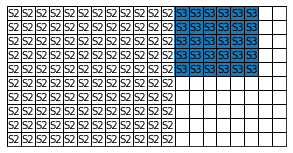

2024-02-02 00:00:00
(20, 10) ['S2', 'S3'] [(10, 12), (5, 6)]


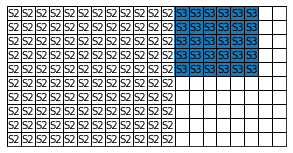

2024-02-03 00:00:00
(20, 10) ['S2', 'S3'] [(10, 12), (5, 6)]


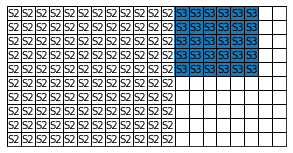

2024-02-04 00:00:00
(20, 10) ['S2', 'S3'] [(10, 12), (5, 6)]


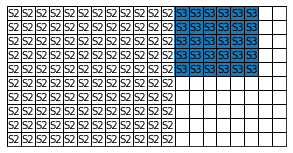

2024-02-05 00:00:00
(20, 10) ['S2', 'S3'] [(10, 12), (5, 6)]


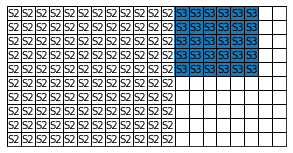

2024-02-06 00:00:00
(20, 10) ['S7', 'S1'] [(10, 10), (9, 10)]


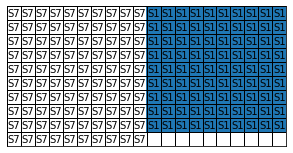

2024-02-07 00:00:00
(20, 10) ['S7', 'S1'] [(10, 10), (9, 10)]


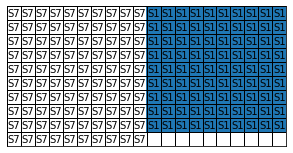

2024-02-08 00:00:00
(20, 10) ['S7', 'S1'] [(10, 10), (9, 10)]


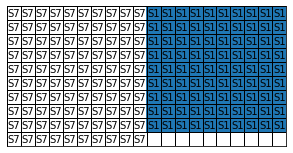

2024-02-09 00:00:00
(20, 10) ['S7', 'S1'] [(10, 10), (9, 10)]


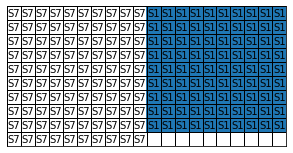

2024-02-10 00:00:00
(20, 10) ['S7', 'S1'] [(10, 10), (9, 10)]


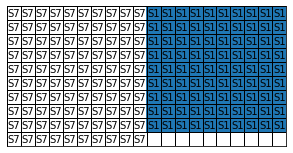

2024-02-11 00:00:00
(20, 10) ['S1', 'S5'] [(9, 10), (9, 10)]


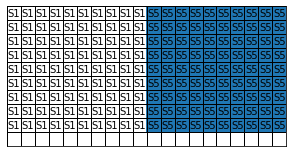

2024-02-12 00:00:00
(20, 10) ['S1', 'S5'] [(9, 10), (9, 10)]


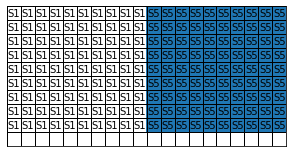

2024-02-13 00:00:00
(20, 10) ['S1', 'S5'] [(9, 10), (9, 10)]


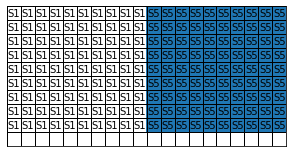

2024-02-14 00:00:00
(20, 10) ['S6', 'S4'] [(8, 10), (5, 6)]


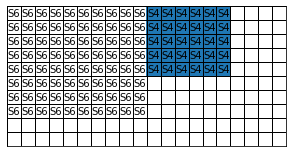

2024-02-15 00:00:00
(20, 10) ['S6', 'S4'] [(8, 10), (5, 6)]


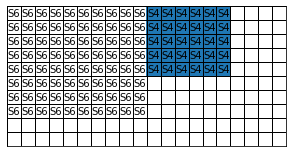

2024-02-16 00:00:00
(20, 10) ['S6', 'S4'] [(8, 10), (5, 6)]


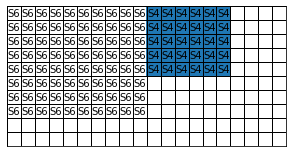

2024-02-17 00:00:00
(20, 10) ['S6', 'S4'] [(8, 10), (5, 6)]


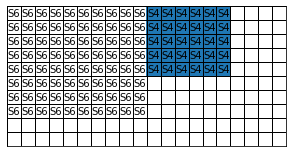

2024-02-18 00:00:00
(20, 10) ['S6', 'S4'] [(8, 10), (5, 6)]


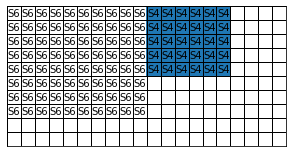

2024-02-19 00:00:00
(20, 10) ['S4'] [(5, 6)]


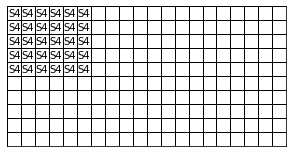

2024-02-20 00:00:00
(20, 10) [] []


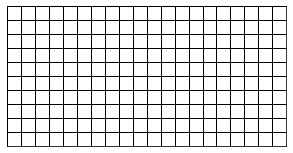

2024-02-21 00:00:00
(20, 10) [] []


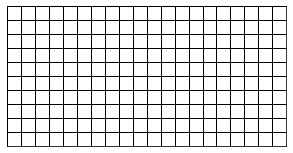

2024-02-22 00:00:00
(20, 10) [] []


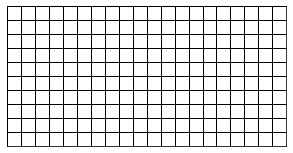

2024-02-23 00:00:00
(20, 10) [] []


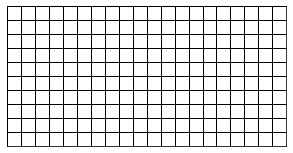

2024-02-24 00:00:00
(20, 10) [] []


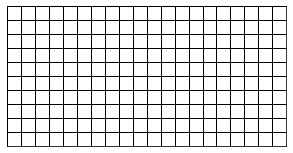

2024-02-25 00:00:00
(20, 10) [] []


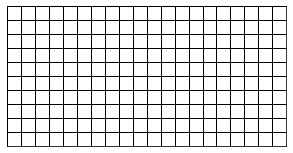

2024-02-26 00:00:00
(20, 10) [] []


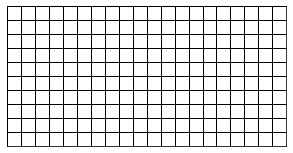

2024-02-27 00:00:00
(20, 10) [] []


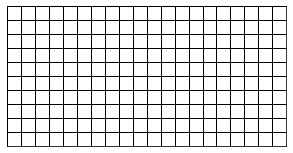

2024-02-28 00:00:00
(20, 10) [] []


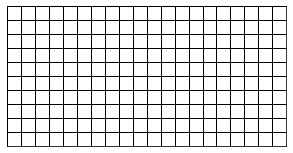

In [361]:
for 조회날짜 in 면적달력.index[:]:
    print(조회날짜)
    정반배치레이아웃("A", 정반데이터, 조회날짜, 블록명달력, 사이즈달력)

In [362]:
# for 조회날짜 in 면적달력.index[:9]:
#     정반배치레이아웃("B", 정반데이터, 조회날짜, 블록명달력, 사이즈달력)

# 결과정리 - 간트차트

In [363]:
fin_df = pd.DataFrame({
    "블록명":결론_블록리스트,
    "정반명":결론_정반리스트,
    "착수일자":결론_착수일자
    })
fin_df

,블록명,정반명,착수일자
0,S2,A,2024-02-01
1,S7,A,2024-02-06
2,S1,A,2024-02-06
3,S5,A,2024-02-11
4,S6,A,2024-02-14
5,S4,A,2024-02-14
6,S3,A,2024-02-01


In [364]:
merged_df = pd.merge(블록데이터, fin_df, on="블록명", how="left")
merged_df

,블록명,중량,표준공기,납기,정반배치,사이즈,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위,정반명,착수일자
0,S2,60,5,2024-02-14,0,"(10, 12)",120,2024-02-09,4.0,4.5,1.0,2.4,A,2024-02-01
1,S7,50,5,2024-02-26,0,"(10, 10)",100,2024-02-21,7.0,4.5,2.0,3.9,A,2024-02-06
2,S1,50,8,2024-02-15,0,"(9, 10)",90,2024-02-07,2.0,1.0,3.5,4.0,A,2024-02-06
3,S5,50,3,2024-02-20,0,"(9, 10)",90,2024-02-17,5.5,7.0,3.5,5.6,A,2024-02-11
4,S6,50,5,2024-02-22,0,"(8, 10)",80,2024-02-17,5.5,4.5,5.0,6.7,A,2024-02-14
5,S4,20,6,2024-02-12,0,"(5, 6)",30,2024-02-06,1.0,2.0,6.5,7.0,A,2024-02-14
6,S3,30,5,2024-02-13,0,"(5, 6)",30,2024-02-08,3.0,4.5,6.5,7.8,A,2024-02-01


In [365]:
@unpack_df_columns
def 종료일구하기(착수일자, 표준공기):
    try:
        original_date = datetime.strptime(착수일자, "%Y-%m-%d")
        종료날짜 = original_date + timedelta(days=int(표준공기)) 
        종료날짜 = 종료날짜.strftime("%Y-%m-%d")
        return 종료날짜
    except:
        pass

In [370]:
@unpack_df_columns
def create_text(블록명, 표준공기, 사이즈):
    return str(블록명)+"/"+"조립중량:"+str(표준공기)+"ton" + "/" +"사이즈:"+str(사이즈)

In [371]:
merged_df["종료일자"] = merged_df[["착수일자", "표준공기"]].apply(종료일구하기, axis=1)
merged_df["차트텍스트"] = merged_df[["블록명", "표준공기", "사이즈"]].apply(create_text, axis=1)
merged_df

,블록명,중량,표준공기,납기,정반배치,사이즈,면적,최소착수요구일,날짜순서,공기순서,크기순서,우선순위,정반명,착수일자,종료일자,차트텍스트
0,S2,60,5,2024-02-14,0,"(10, 12)",120,2024-02-09,4.0,4.5,1.0,2.4,A,2024-02-01,2024-02-06,"S2/조립중량:5ton/사이즈:(10, 12)"
1,S7,50,5,2024-02-26,0,"(10, 10)",100,2024-02-21,7.0,4.5,2.0,3.9,A,2024-02-06,2024-02-11,"S7/조립중량:5ton/사이즈:(10, 10)"
2,S1,50,8,2024-02-15,0,"(9, 10)",90,2024-02-07,2.0,1.0,3.5,4.0,A,2024-02-06,2024-02-14,"S1/조립중량:8ton/사이즈:(9, 10)"
3,S5,50,3,2024-02-20,0,"(9, 10)",90,2024-02-17,5.5,7.0,3.5,5.6,A,2024-02-11,2024-02-14,"S5/조립중량:3ton/사이즈:(9, 10)"
4,S6,50,5,2024-02-22,0,"(8, 10)",80,2024-02-17,5.5,4.5,5.0,6.7,A,2024-02-14,2024-02-19,"S6/조립중량:5ton/사이즈:(8, 10)"
5,S4,20,6,2024-02-12,0,"(5, 6)",30,2024-02-06,1.0,2.0,6.5,7.0,A,2024-02-14,2024-02-20,"S4/조립중량:6ton/사이즈:(5, 6)"
6,S3,30,5,2024-02-13,0,"(5, 6)",30,2024-02-08,3.0,4.5,6.5,7.8,A,2024-02-01,2024-02-06,"S3/조립중량:5ton/사이즈:(5, 6)"


In [372]:
import plotly.express as px
def draw_gant(df):
    fig = px.timeline(
        
        df, 
        x_start="착수일자", 
        x_end="종료일자", 
        y="블록명",
        color="정반명",
        hover_data = ["표준공기", "중량"],
        text = "차트텍스트",
        opacity=0.7
        )

    fig.update_yaxes(autorange="reversed")          #if not specified as 'reversed', the tasks will be listed from bottom up       
    fig.update_layout(
                    # title='Project Plan Gantt Chart',
                    hoverlabel_bgcolor='#DAEEED',   #Change the hover tooltip background color to a universal light blue color. If not specified, the background color will vary by team or completion pct, depending on what view the user chooses
                    bargap=0.2,
                    height=500,              
                    xaxis_title="", 
                    yaxis_title="정반명", 
                    font=dict(
                        family="Courier New, monospace",
                        size=12,  # Set the font size here
                        color="RebeccaPurple"
                        ),
    )
    fig.show()

In [373]:
draw_gant(merged_df)